## Settings

In [ ]:
!pip install selenium
!apt-get update

# (최초 1회)
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks' #
!pip install chromedriver-autoinstaller
!python --version

import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve
import re
import ast
import time
import pandas as pd
import numpy as np
import chromedriver_autoinstaller  # setup chrome options
from tqdm import tqdm  # tqdm 라이브러리를 임포트합니다.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,560 kB]
Get:11 http://archive.ubuntu.com/ubu

In [ ]:
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어
chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

chromedriver_autoinstaller.install()  # set the target URL

# 1. Data crawling

In [ ]:
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어

chromedriver_autoinstaller.install()  # set the target URL

driver = webdriver.Chrome(options=chrome_options)

## Link crawling

Code that collects links that need to be crawled

In [ ]:
def get_links(url):
  driver = webdriver.Chrome(options=chrome_options)
  driver.get(url)
  prds=driver.find_elements(By.CSS_SELECTOR, "div.prd_info")
  hrefs=[]
  links=[]
  for prd in prds:
    a_tags = prd.find_elements(By.TAG_NAME, "a")
    hrefs.append(a.get_attribute("href") for a in a_tags if a.get_attribute("href"))
  for href in hrefs:
    for link in href:
      if link!='javascript:;':
        links.append(link)
  driver.quit()
  return links

## Product information crawling

Code to crawl information for each product

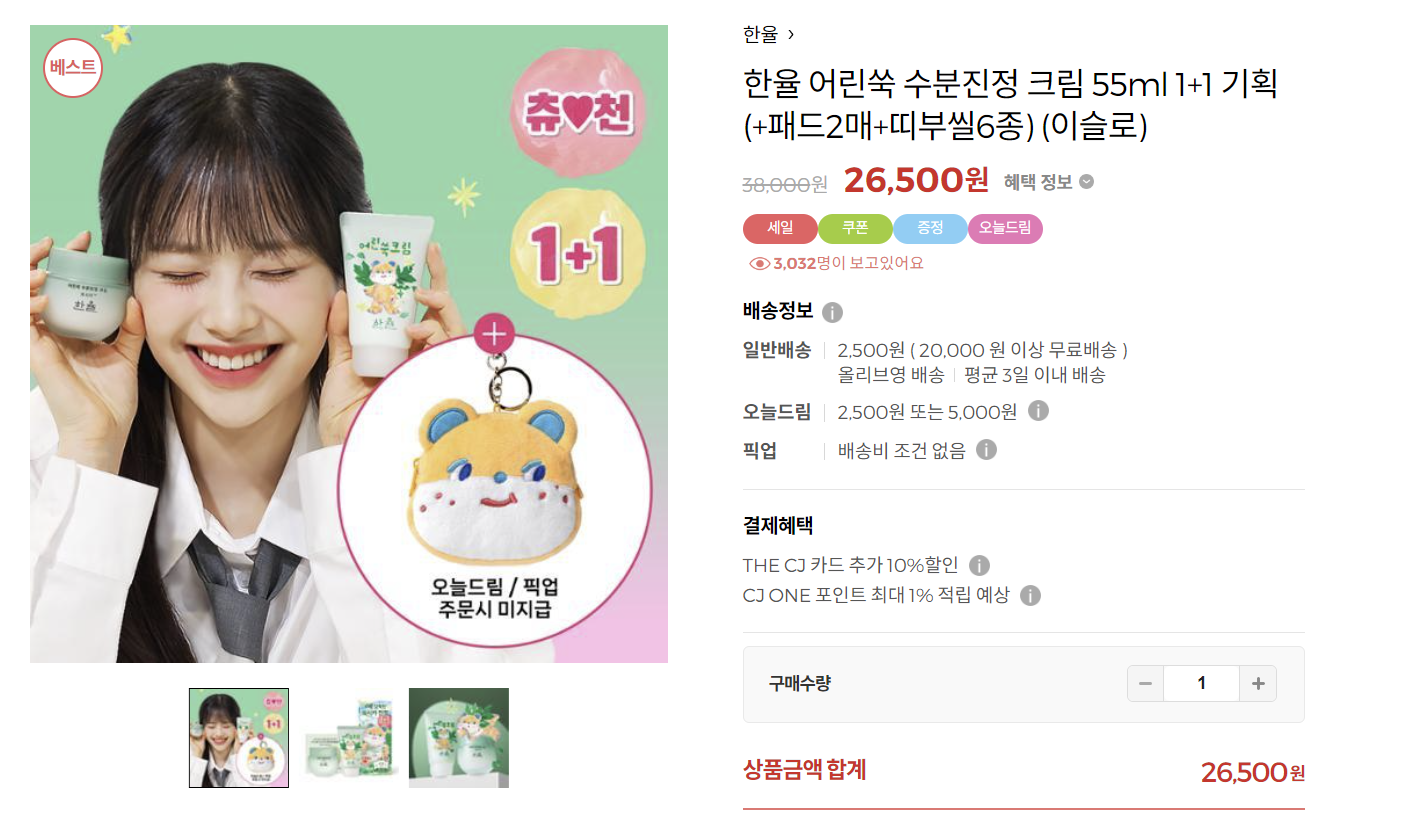

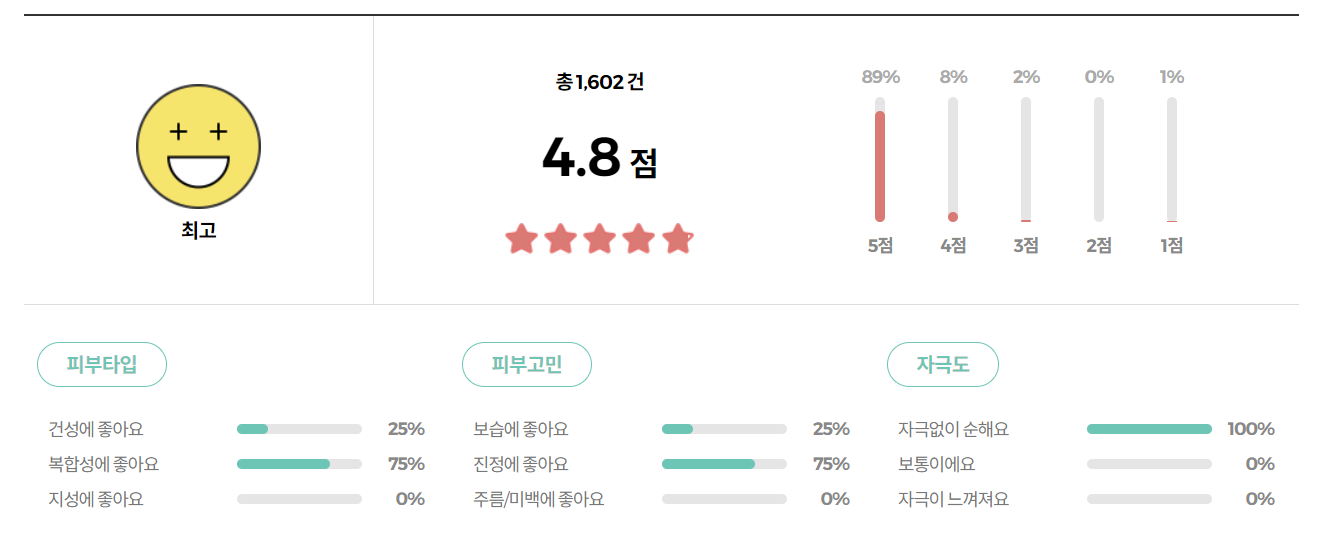

In [ ]:
# converting review grade to number
def convert_review_grade(grade):
    if grade == "최고":
        return 5
    elif grade == "좋음":
        return 4
    elif grade == "보통":
        return 3
    elif grade == "별로":
        return 2
    elif grade == "나쁨":
        return 1
    else:
        return None

def scrape_product_info(url):
    # 웹드라이버 초기화
    driver = webdriver.Chrome(options=chrome_options)

    # 주어진 URL 열기
    driver.get(url)

    # 리뷰 버튼 클릭
    button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="reviewInfo"]/a'))
    )
    button.click()
    #time.sleep(3)

    # 브랜드 정보 크롤링
    brand_name_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_brand'))
    )
    brand_name = brand_name_element.text

    # 제품명 크롤링
    product_name_element = driver.find_element(By.CSS_SELECTOR, 'p.prd_name')
    product_name = product_name_element.text

    # 가격 정보 크롤링
    try:
        price = driver.find_element(By.CSS_SELECTOR, 'div.price')
        original_price_element = price.find_element(By.CSS_SELECTOR, 'span.price-1')
        original_price = original_price_element.text
        final_price_element = price.find_element(By.CSS_SELECTOR, 'span.price-2')
        final_price = final_price_element.text
    except:
        # 가격 정보가 다를 경우 처리
        price = driver.find_element(By.CSS_SELECTOR, 'span.tx_num')
        original_price = price.text
        final_price = price.text

    # 리뷰 정보 크롤링
    try:
        review_section = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div.review_wrap.renew.review-reward-notice'))
        )

        # 리뷰 등급 요소 찾기
        review_face = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div.grade_img'))
        )
        #review_face = review_section.find_element(By.CSS_SELECTOR, 'div.grade_img')


        # 리뷰 등급 텍스트 가져오기
        grade_text = review_face.find_element(By.CSS_SELECTOR, 'em').text if review_face else np.nan

        # 리뷰 등급 텍스트를 숫자로 변환
        review_grades = convert_review_grade(grade_text)

    except:
        review_grades = np.nan

    # 리뷰 점수별 퍼센트 크롤링
    try:
        rating = review_section.find_element(By.CSS_SELECTOR, 'div > div.graph_area > ul')
        ratings_elements = rating.find_elements(By.CSS_SELECTOR, 'span.per')
        ratings = [element.text for element in ratings_elements]

    except:
        ratings = np.nan

    # 피부타입, 피부고민, 자극도 항목별 퍼센트 크롤링
    try:
        skin_infos = review_section.find_elements(By.CSS_SELECTOR, 'dl.poll_type2.type3')
        skin_info_elements = [element.find_elements(By.CSS_SELECTOR, 'span.txt') for element in skin_infos]
        skin_category = [[element.text for element in skin_category] for skin_category in skin_info_elements]

        skin_per_elements = [element.find_elements(By.CSS_SELECTOR, 'em.per') for element in skin_infos]
        skin_per = [[element.text for element in skin_category] for skin_category in skin_per_elements]
        skin_info={}
        for c, p in zip(skin_category, skin_per):
            for category, per in zip(c,p):
              skin_info[category] = per
    except:
        skin_infos = np.nan
    # 드라이버 종료
    driver.quit()

    # 데이터를 딕셔너리로 저장
    data = {
        "브랜드": [brand_name],
        "제품명": [product_name],
        "원래 가격": [original_price],
        "최종 가격": [final_price],
        "리뷰 등급": [review_grades],
        "리뷰 점수별 퍼센트": [ratings],
        "리뷰 점수 항목별 퍼센트": [skin_info]
    }

    # 데이터프레임으로 만들기
    df = pd.DataFrame(data)

    return df


## review information crawling

Code to crawl review information for each product

In [ ]:
def collect_reviews(product_url):
    # 메인 데이터프레임 초기화
    reviews_df = pd.DataFrame(columns=['제품명', '리뷰어', '리뷰어 정보', '별점', '한달이상사용', '재구매여부', '피부타입', '피부고민', '자극도', '리뷰내용'])

    # 드라이버 초기화
    driver = webdriver.Chrome(options=chrome_options)

    # 상품 페이지로 이동
    driver.get(product_url)

    # 페이지 로딩 대기
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="reviewInfo"]/a')))

    # 상품명 크롤링 (PK)
    product_name_element = driver.find_element(By.XPATH, '//*[@id="Contents"]/div[2]/div[2]/div/p[2]')
    product_name = product_name_element.text

    # 리뷰 버튼 클릭
    button = driver.find_element(By.XPATH, '//*[@id="reviewInfo"]/a')
    button.click()
    try:
      # 리뷰 섹션 로딩 대기
      review_section = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'review_cont')))
      driver.execute_script("arguments[0].scrollIntoView(true);", review_section)
    except:
      return reviews_df
    # 리뷰 요소들을 가져오기
    reviews = driver.find_elements(By.CLASS_NAME, 'review_cont')
    reviewers = driver.find_elements(By.CLASS_NAME, 'info_user')

    # 리뷰어 정보

    for review, reviewer in zip(reviews, reviewers):
        new_row = {}  # 각 리뷰의 데이터를 저장할 임시 딕셔너리

        new_row['제품명'] = product_name

        # 리뷰어 아이디
        new_row['리뷰어'] = reviewer.find_element(By.CLASS_NAME, 'id').text if reviewer.find_elements(By.CLASS_NAME, 'id') else np.nan
        # 리뷰어 정보 (예: 나이, 성별 등)
        reviewer_info = reviewer.find_element(By.XPATH, '..').find_element(By.CLASS_NAME, 'tag') if reviewer.find_element(By.XPATH, '..').find_elements(By.CLASS_NAME, 'tag') else np.nan
        new_row['리뷰어 정보'] = [e.text for e in reviewer_info.find_elements(By.CSS_SELECTOR, 'span')] if type(reviewer_info) != float else np.nan

        # 별점
        new_row['별점'] = review.find_element(By.CLASS_NAME, 'point').text if review.find_elements(By.CLASS_NAME, 'point') else np.nan

        # 한달이상사용 여부 및 재구매여부
        month_rebuy = [element.text for element in reviewer.find_element(By.XPATH, '..').find_elements(By.CLASS_NAME, 'badge')]
        new_row['한달이상사용'] = 1 if any('한달' in text for text in month_rebuy) else 0
        new_row['재구매여부'] = 1 if any('재구매' in text for text in month_rebuy) else 0

        # 피부타입, 피부고민, 자극도
        polls = review.find_elements(By.CLASS_NAME, 'poll_type1')
        new_row['피부타입'] = polls[0].text.split("\n")[1] if len(polls) > 0 else np.nan
        new_row['피부고민'] = polls[1].text.split("\n")[1] if len(polls) > 1 else np.nan
        new_row['자극도'] = polls[2].text.split("\n")[1] if len(polls) > 2 else np.nan

        # 리뷰 내용
        new_row['리뷰내용'] = review.find_element(By.CLASS_NAME, 'txt_inner').text if review.find_elements(By.CLASS_NAME, 'txt_inner') else np.nan

        # 새로운 행을 DataFrame에 추가
        reviews_df = pd.concat([reviews_df, pd.DataFrame([new_row])], ignore_index=True)

    # 드라이버 종료
    driver.quit()

    return reviews_df

## Integrated Crawling

Code for collecting data for each item while traversing the collected links

In [ ]:
# 데이터프레임을 저장할 빈 리스트 초기화
result_product_list = []
result_review_list = []
urls=[f"https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&fltDispCatNo=&prdSort=01&pageIdx={i}&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010015_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%ED%81%AC%EB%A6%BC&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd="for i in range(1, 15)]

# 각 URL에 대해 데이터 스크래핑 실행
for url in urls:
  for link in tqdm(get_links(url), desc="Scraping progress"):
      product_df = scrape_product_info(link)
      reviews_df = collect_reviews(link)
      result_product_list.append(product_df)
      result_review_list.append(reviews_df)

# 모든 데이터프레임을 하나로 연결
result_product_df = pd.concat(result_product_list, ignore_index=True)
result_review_df = pd.concat(result_review_list, ignore_index=True)

# 데이터프레임 저장
result_product_df.to_excel("olive_young.xlsx")
result_review_df.to_excel("olive_young_reviews.xlsx")

Scraping progress:  81%|████████▏ | 39/48 [27:03<05:12, 34.72s/it]

# 2. Data preprocessing

**상품 정보 데이터**

1. '원래 가격' 및 '최종 가격'
=> ","와 "원"이 있다면 빼고 int로 만들어서 저장

2.  '리뷰 수'
=> ","를 빼고 int로 만들어서 저장

3. 점수별 퍼센트
{'5점': '93%', '4점': '6%', '3점': '1%', '2점': '0%', '1점': '0%'}
이런식으로 되어 있는데, 점수 비율_5점, 점수 비율_4점, ..., 점수 비율_1점 컬럼 만들고 % 제거 하고 int로 만들어서 저장

4. 리뷰 점수 항목별 퍼센트
{'피부타입': {'건성에 좋아요': '35%', '복합성에 좋아요': '59%', '지성에 좋아요': '7%'}, '피부고민': {'보습에 좋아요': '33%', '진정에 좋아요': '18%', '주름/미백에 좋아요': '49%'}, '자극도': {'자극없이 순해요': '62%', '보통이에요': '35%', '자극이 느껴져요': '3%'}}

이런식으로 돼있는데,
피부타입_건성에 좋아요, 피부타입_복합성에 좋아요, ..., 자극도_자극이 느껴져요와 같은 다음의 형태로 %빼고 int로 바꿔서 저장

**리뷰 정보 데이터**

1. "별점" 컬럼에서
5점만점에 4점 이런식으로 돼있는데,
regex 이용해서 '만점에 {i}점'에 오는 i만 가져와서 int로 저장

2. "피부타입" 컬럼을 원핫인코딩해서 각각 피부타입_복합성에 좋아요 와 같은 식으로 저장하고, int 형태로 저장

3. "피부고민" 컬럼도 원핫인코딩하고 int로 저장

4. "자극도" 컬럼도 원핫인코딩하고 int로 저장


In [ ]:
import pandas as pd


# 파일 로드
file_path = 'olive_young.xlsx'
df = pd.read_excel(file_path)

# 1. '원래 가격' 및 '최종 가격' 전처리
df['원래 가격'] = df['원래 가격'].str.replace(',', '').str.replace('원', '').str.replace('\n','').str.replace('~', '').str.replace(' ', '').astype(int)
df['최종 가격'] = df['최종 가격'].str.replace(',', '').str.replace('원', '').str.replace('\n','').str.replace('~', '').str.replace(' ', '').astype(int)

# 2. '리뷰 수' 전처리

#df['리뷰 수'] = df['리뷰 수'].str.replace(',', '').str.replace('(', '').str.replace(')', '').astype(int)

# 3. 점수별 퍼센트 전처리
# 결측치 처리 먼저
df["리뷰 점수별 퍼센트"].fillna("['0%', '0%', '0%', '0%', '0%']", inplace = True)

for i in range(1, 6):
    df[f'점수 비율_{i}점'] = df['리뷰 점수별 퍼센트'].apply(lambda x: int(ast.literal_eval(x)[5-i].replace('%', '')))

# 4. 리뷰 점수 항목별 퍼센트 전처리
# 결측치 처리 먼저
df.loc[df["리뷰 점수 항목별 퍼센트"] == '{}', "리뷰 점수 항목별 퍼센트"] = "{'건성에 좋아요': '0%', '복합성에 좋아요': '0%', '지성에 좋아요': '0%', '보습에 좋아요': '0%', '진정에 좋아요': '0%', '주름/미백에 좋아요': '0%', '자극없이 순해요': '0%', '보통이에요': '0%', '자극이 느껴져요': '0%'}"

categories = ['피부타입', '피부고민', '자극도']
keys = [['건성에 좋아요', '복합성에 좋아요', '지성에 좋아요'], ['보습에 좋아요', '진정에 좋아요', '주름/미백에 좋아요'], ['자극없이 순해요', '보통이에요', '자극이 느껴져요']]
for i in range(3):
    for key in keys[i]:
        col_name = f'{categories[i]}_{key}'
        df[col_name] = df['리뷰 점수 항목별 퍼센트'].apply(lambda x: int(ast.literal_eval(x)[key].replace('%', '')))

# '점수별 퍼센트' 및 '리뷰 점수 항목별 퍼센트' 원본 컬럼은 필요없으니 삭제
df = df.drop(columns=['리뷰 점수별 퍼센트', '리뷰 점수 항목별 퍼센트'])

# 전처리된 데이터 저장
df.to_excel('olive_young_processed.xlsx', index=False)

# 결과 확인
print(df.head())


   Unnamed: 0    브랜드                                                제품명  \
0           0   제로이드              [8/27하루특가/민가든 PICK] 제로이드 인텐시브 크림 80ml   
1           1    토리든  [8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...   
2           2  에스네이처  [8월 올영픽/수분천재크림] 에스네이처 아쿠아 스쿠알란 수분크림 60ml 더블 기획...   
3           3    닥터지        [굿즈증정/1+1]닥터지 레드 블레미쉬 클리어 수딩 크림 70ml 1+1 기획   
4           4   에스트라  에스트라 아토베리어365 크림 80ml 기획 (+하이드로에센스 25ml+리제덤세럼 ...   

   원래 가격  최종 가격  리뷰 등급      리뷰 수  점수 비율_1점  점수 비율_2점  점수 비율_3점  ...  점수 비율_5점  \
0  32000  25600    5.0      (33)         0         0         0  ...       100   
1  42000  27930    5.0  (13,711)         0         1         3  ...        86   
2  43000  23200    5.0  (24,879)         1         1         3  ...        84   
3  38000  28800    5.0   (3,664)         0         0         2  ...        91   
4  33000  28220    5.0   (7,621)         1         1         2  ...        90   

   피부타입_건성에 좋아요  피부타입_복합성에 좋아요  피부타입_지성에 좋아요  피부고민_보습에 좋아요  피부

In [ ]:
# 파일 로드
file_path = 'olive_young_reviews.xlsx'
df = pd.read_excel(file_path)

#피부타입, 피부고민, 자극도에 대한 리뷰가 없는 경우 삭제
df=df[df.피부타입.notna()]
df=df[df.피부고민.notna()]
df=df[df.자극도.notna()]

# 1. '별점' 컬럼에서 '만점에 {i}점'에 오는 i만 추출하여 int로 저장
df['별점'] = df['별점'].apply(lambda x: int(re.search(r'(\d+)점$', x).group(1)))

# 2. '피부타입' 컬럼을 원핫인코딩
df['피부타입'] = df['피부타입'].apply(lambda x: x.split('\n')[1])
skin_type_dummies = pd.get_dummies(df['피부타입'], prefix='피부타입')

# 3. '피부고민' 컬럼을 원핫인코딩
df['피부고민'] = df['피부고민'].apply(lambda x: x.split('\n')[1])
skin_concern_dummies = pd.get_dummies(df['피부고민'], prefix='피부고민')

# 4. '자극도' 컬럼을 원핫인코딩
df['자극도'] = df['자극도'].apply(lambda x: x.split('\n')[1])
sensitivity_dummies = pd.get_dummies(df['자극도'], prefix='자극도')

# 원핫인코딩된 데이터프레임을 기존 데이터프레임과 병합
df = pd.concat([df, skin_type_dummies, skin_concern_dummies, sensitivity_dummies], axis=1)

# 원본 컬럼 삭제
df.drop(columns=['피부타입', '피부고민', '자극도'], inplace=True)

# 전처리된 데이터 저장
df.to_excel('olive_young_reviews_processed.xlsx', index=False)

# 결과 확인
print(df.head())


   Unnamed: 0                           제품명   리뷰어  \
0           0  [민가든 PICK] 제로이드 인텐시브 크림 80ml  딥한홍조   
1           1  [민가든 PICK] 제로이드 인텐시브 크림 80ml  코코천사   
2           2  [민가든 PICK] 제로이드 인텐시브 크림 80ml   야호얍   
3           3  [민가든 PICK] 제로이드 인텐시브 크림 80ml   혜혜1   
4           4  [민가든 PICK] 제로이드 인텐시브 크림 80ml    룽륭   

                          리뷰어 정보  별점  한달이상사용  재구매여부  \
0   ['민감성', '여름쿨톤', '미백', '민감성']   5       0      0   
1  ['복합성', '겨울쿨톤', '각질', '다크서클']   5       0      0   
2            ['건성', '웜톤', '민감성']   5       0      0   
3                            NaN   5       0      0   
4               ['트러블성', '피지과다']   5       0      0   

                                                리뷰내용  피부타입_건성에 좋아요  \
0  화장품 이것저것 발라보다가 피부염으로 고생하고나서 기초 마무리 크림은 꼭 장벽크림을...          True   
1  요즘 야외에서는 땀을 많이 흘리고, 실내에서는 에어컨 바람을 많이 쐬니 땀띠처럼 목...          True   
2  요즘 과하게 각질 제거를 했다니 피부가 다 뒤집어져서 쓰던 크림도 맞지 않아 급하게...          True   
3  요즘 피부장벽이 약해진 것 같아서 순한 장벽케어 크림을 찾다가 이전에 제로이드 크림...          True   


# 3. Recommendation system

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip install sentence_transformers

from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import re
import ast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## 1. Filter based on user characteristics and product characteristics

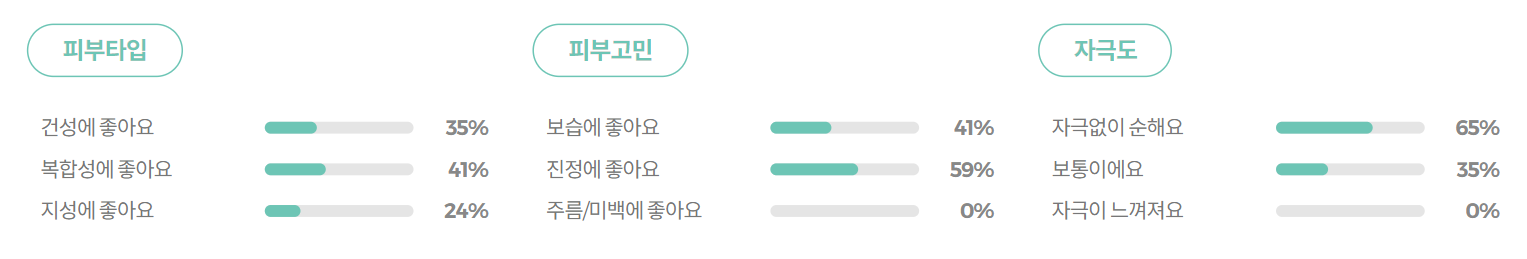

In [ ]:
def filter_product(df, feature):
  df=df[df[f'피부타입_{feature[0]}'] == df[['피부타입_건성에 좋아요', '피부타입_복합성에 좋아요', '피부타입_지성에 좋아요']].max(axis=1)]
  df=df[df[f'피부고민_{feature[1]}'] == df[['피부고민_보습에 좋아요', '피부고민_진정에 좋아요', '피부고민_주름/미백에 좋아요']].max(axis=1)]
  df=df[df[f'자극도_{feature[2]}'] == df[['자극도_자극없이 순해요', '자극도_보통이에요', '자극도_자극이 느껴져요']].max(axis=1)]

  return df

df=pd.read_excel('olive_young_processed.xlsx')
prds = filter_product(df, ['복합성에 좋아요', '보습에 좋아요', '자극없이 순해요'])

reviews = pd.read_excel('olive_young_reviews.xlsx')
filtered_products_df = reviews[reviews['제품명'].isin(prds['제품명'])]

## 2. Semantic Search

1. 제품별 제품명 + 리뷰 내용을 Sentence Transformer를 활용하여 임베딩 벡터를 계산합니다.

2. 주어진 유저 query에 대해, Sentence Transformer로 임베딩을 한 뒤, 이미 구해진 제품별 임베딩 벡터들간의 코사인 유사도를 계산합니다.

3. 코사인 유사도를 기반으로, 제품별 추천을 구현합니다.

In [ ]:
# SentenceTransformer 모델 로드
model = SentenceTransformer('bespin-global/klue-sroberta-base-continue-learning-by-mnr') # 다른 임베딩 모델을 서치해도 됩니다. (권장)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#위의 코드에서 필터링된 df을 semantic search 용도로 사용
reviews_df = filtered_products_df.loc[:, ['제품명', '리뷰내용']]
print(reviews_df)

                                                    제품명  \
10    [8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...   
11    [8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...   
12    [8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...   
13    [8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...   
14    [8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...   
...                                                 ...   
6070      비욘드 엔젤아쿠아 보습장벽 크림 150ml 1+1 리필기획(+10ml*2+스티커)   
6071      비욘드 엔젤아쿠아 보습장벽 크림 150ml 1+1 리필기획(+10ml*2+스티커)   
6072      비욘드 엔젤아쿠아 보습장벽 크림 150ml 1+1 리필기획(+10ml*2+스티커)   
6073      비욘드 엔젤아쿠아 보습장벽 크림 150ml 1+1 리필기획(+10ml*2+스티커)   
6074      비욘드 엔젤아쿠아 보습장벽 크림 150ml 1+1 리필기획(+10ml*2+스티커)   

                                                   리뷰내용  
10        여름이라서 가벼운 수분 로션을 찾고 있었는데 피부 온도도 낮춰주고 발림성도 좋아요  
11    이 수분크림은 듬뿍 발라도 흡수가 사아악 되서 너무 좋아요 이걸루 수분충전 해주고 ...  
12    뭐가 남나요? 땅 파서 장사하나요???\n\n여름에 진짜 진짜 바르기 좋은\n시원하...  
13    토리든 다이브인 수딩크림 더블기획 100미리*2 브랜든 파우치증정 상품 구매했습니다...  
1

In [ ]:
# 제품명 임베딩
product_names = reviews_df['제품명'].astype(str).tolist()
product_name_embeddings_dict = {}
for product_name in tqdm(product_names, desc="Encoding product names"):
    product_name_embeddings_dict[product_name]= model.encode(product_name)

# reviews_df에 임베딩 추가
reviews_df['product_name_embedding'] = reviews_df['제품명'].map(product_name_embeddings_dict)

# list 형식으로 변환
reviews_df['product_name_embedding'] = reviews_df['product_name_embedding'].apply(lambda x: x.tolist())


Encoding product names: 100%|██████████| 2207/2207 [05:26<00:00,  6.75it/s]


In [ ]:
# 리뷰 내용 임베딩
review_texts = reviews_df['리뷰내용'].astype(str).tolist()
review_embeddings = []
for review_text in tqdm(review_texts, desc="Encoding review texts"):
    review_embeddings.append(model.encode(review_text))

# reviews_df에 임베딩 추가
reviews_df['review_content_embedding'] = review_embeddings

# list 형식으로 변환
reviews_df['review_content_embedding'] = reviews_df['review_content_embedding'].apply(lambda x: x.tolist())

Encoding review texts: 100%|██████████| 2207/2207 [16:40<00:00,  2.21it/s]


In [ ]:
# 유사도 계산 함수
def calculate_cosine_similarity(query_embedding, embeddings):
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    return similarities

# 사용자의 쿼리에 대한 임베딩 생성 및 유사도 계산 및 높은 유사도 순 추천 아이템 출력
def get_top_products_by_similarity(query, reviews_df):
    query_embedding = model.encode(query)

    # 제품명과 유사도 계산 칼럼 추가
    product_name_embeddings = np.array(reviews_df['product_name_embedding'].tolist())
    reviews_df['name_cosine_similarity'] = calculate_cosine_similarity(query_embedding, product_name_embeddings)

    # 리뷰와 유사도 계산 칼럼 추가
    review_content_embeddings = np.array(reviews_df['review_content_embedding'].tolist())
    reviews_df['review_cosine_similarity'] = review_similarities = calculate_cosine_similarity(query_embedding, review_content_embeddings)

    reviews_df['simlarity_average'] = reviews_df[['name_cosine_similarity', 'review_cosine_similarity']].mean(axis=1)

    # 'embedding_average'를 기준으로 내림차순 정리
    sorted_reviews_df = reviews_df.sort_values(by='simlarity_average', ascending=False)
    print(sorted_reviews_df.head(10))
    print(sorted_reviews_df['제품명'].head(10))

In [ ]:
# 테스트 쿼

queries = ["갑자기 여드름 났을 때 진정시키기 좋은 크림",
           "안끈적거리고 가벼운 크림",
           "극건성에 좋은 꾸덕한 크림",
           "메이크업용 수분크림"]

In [ ]:
for query in queries:
  print(f"Query: {query}")
  print(get_top_products_by_similarity(query, reviews_df))
  print()

Query: 갑자기 여드름 났을 때 진정시키기 좋은 크림
                                                   제품명  \
2171                             라타플랑 미나리 진정 수분크림 75ml   
2279                      [NEW] 브링그린 쑥세라카밍모이스처젤크림 75mL   
2167                             라타플랑 미나리 진정 수분크림 75ml   
763                   [NEW]브링그린 쑥세라카밍모이스처젤크림 75mL 더블기획   
1189  [모공탄력]닥터지 레드 블레미쉬 바쿠치올 포어젯 크림 50ml 기획 (+세럼 10ml)   
...                                                ...   
3609     마녀공장 비피다 바이옴 아쿠아 배리어 크림 80ml 증정기획 (+20mlx2ea)   
1928     마녀공장 비피다 바이옴 아쿠아 배리어 크림 80ml 증정기획 (+20mlx2ea)   
3871                           비오템 아쿠아수르스 수분 젤 크림 30ml   
1028   [24시간수분잠금] 아비브 수분초 히알루론 크림 하이드레이팅 팟 80ml 1+1 기획   
3293                                           가히 아쿠아밤   

                                                   리뷰내용  \
2171  봄과 여름처럼 날씨 따뜻하거나 더울 때 여드름성 피부분들이 쓰기 찰떡인 제품입니다~...   
2279  우연히 엄청 할인 하고 있을 때 구매 했어요!!!\n최근에 크림을 바꾸고 얼굴에 좁...   
2167  이거 쓰고 안 나던 좁쌀여드름이 나서 얼굴이 뒤집어졌어요. 처음엔 헤어오일때문인가 ...   
763   우연히 엄청 할인 하고 있을 때 구매 했어요!!!\n

In [ ]:
#추천시스템

user_query = input("검색어를 입력하세요: ")
user_feature = [0,0,0]
a = input("피부 타입을 입력하세요\n 1: 건성 2: 복합성 3: 지성\n")
b = input("피부 고민을 입력하세요\n 1: 보습 2: 진정 3: 주름/미백\n")
c = input("자극도를 입력하세요\n 1: 자극없는 2: 보통 3: 자극있는\n")
if a == '1':
  user_feature[0] = '건성에 좋아요'
elif a == '2':
  user_feature[0] = '복합성에 좋아요'
elif a == '3':
  user_feature[0] = '지성에 좋아요'

if b == '1':
  user_feature[1] = '보습에 좋아요'
elif b == '2':
  user_feature[1] = '진정에 좋아요'
elif b == '3':
  user_feature[1] = '주름/미백에 좋아요'

if c == '1':
  user_feature[2] = '자극없이 순해요'
elif c == '2':
  user_feature[2] = '보통이에요'
elif c == '3':
  user_feature[2] = '자극이 느껴져요'

df = pd.read_excel("olive_young_processed.xlsx")
prds = filter_product(df, user_feature)
reviews = pd.read_excel('olive_young_reviews.xlsx')
filtered_products_df = reviews[reviews['제품명'].isin(prds['제품명'])]
reviews_df = filtered_products_df.loc[:, ['제품명', '리뷰내용']]

# 제품명 임베딩
product_names = reviews_df['제품명'].astype(str).tolist()
product_name_embeddings_dict = {}
for product_name in tqdm(product_names, desc="Encoding product names"):
    product_name_embeddings_dict[product_name]= model.encode(product_name)

# reviews_df에 임베딩 추가
reviews_df['product_name_embedding'] = reviews_df['제품명'].map(product_name_embeddings_dict)

# list 형식으로 변환
reviews_df['product_name_embedding'] = reviews_df['product_name_embedding'].apply(lambda x: x.tolist())

# 리뷰 내용 임베딩
review_texts = reviews_df['리뷰내용'].astype(str).tolist()
review_embeddings = []
for review_text in tqdm(review_texts, desc="Encoding review texts"):
    review_embeddings.append(model.encode(review_text))

# reviews_df에 임베딩 추가
reviews_df['review_content_embedding'] = review_embeddings

# list 형식으로 변환
reviews_df['review_content_embedding'] = reviews_df['review_content_embedding'].apply(lambda x: x.tolist())

print("추천결과")
print(get_top_products_by_similarity(query, reviews_df))

검색어를 입력하세요: 여드름 진정에 좋은 크림
피부 타입을 입력하세요
 1: 건성 2: 복합성 3: 지성1
피부 고민을 입력하세요
 1: 보습 2: 진정 3: 주름/미백2
자극도를 입력하세요
 1: 자극없는 2: 보통 3: 자극있는1


Encoding review texts: 100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


                                                    제품명  \
664   [글로벌 2600만개 판매] 유세린 하이알루론 3X 나이트크림 50ml 기획(+나이...   
4606                       피부미 센텔루션 시카 크림 3X 100ml [건성]   
4111             [NEW]수려한 효비담 수분샘크림 75ml 기획 (+25ml*2ea)   
3111             [NEW]수려한 효비담 수분샘크림 75ml 기획 (+25ml*2ea)   
2715                              라네즈 워터뱅크 인텐시브 크림 45ml   
2712                              라네즈 워터뱅크 인텐시브 크림 45ml   
3115             [NEW]수려한 효비담 수분샘크림 75ml 기획 (+25ml*2ea)   
4115             [NEW]수려한 효비담 수분샘크림 75ml 기획 (+25ml*2ea)   
665   [글로벌 2600만개 판매] 유세린 하이알루론 3X 나이트크림 50ml 기획(+나이...   
667   [글로벌 2600만개 판매] 유세린 하이알루론 3X 나이트크림 50ml 기획(+나이...   

                                                   리뷰내용  \
664   앰플 잘 사용하고 있어서 크림도 구매해봤어요. 여름에 무겁고 환절기나 겨울 보습 제...   
4606      이 크림은 건성 피부에 맞게 촉촉한 수분크림의 제형이에요 가볍고 자극이 없습니다.   
4111  안티에이징 국민 수분크림으로 산뜻하게 수분을 채워주는 제품입니다.\n나이가 들수록 ...   
3111  안티에이징 국민 수분크림으로 산뜻하게 수분을 채워주는 제품입니다.\n나이가 들수록 ...   
2715  민감피부\n건성\n요즘 제피부에 맞는 크림이 없어서 너무 고민이였는데 세일에 추가증...